Fabrycki Łukasz 82623
# LABORATORIUM 9

Generowany obraz:

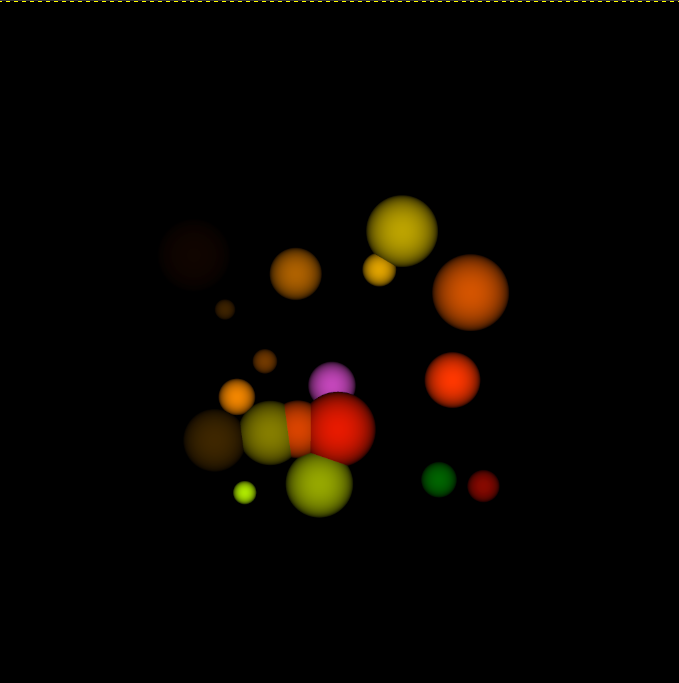

Ten program jest implementacją symulacji odbicia światła od kul w trójwymiarowym świecie z wykorzystaniem technologii GPU (procesora graficznego). W programie zdefiniowano strukturę danych Sphere, która zawiera informacje o kolorze, położeniu i promieniu kuli oraz metodę hit(), która symuluje odbicie światła od kuli i zwraca głębokość, na której znajduje się punkt odbicia. Następnie zdefiniowano funkcję kernel() jako kernel CUDA, która będzie uruchamiana na GPU. Ta funkcja przyjmuje tablicę kul s i tablicę bitową ptr jako argumenty. Każdy wątek GPU obliczy kolor dla pojedynczego piksela na obrazie, biorąc pod uwagę położenie wątku i indeks bloku. Współrzędne x i y obliczane są jako położenie wątku w bloku, przesunięte o położenie bloku w sieci bloków. Współrzędne ox i oy obliczane są jako różnica między położeniem piksela a połową rozmiaru obrazu. Następnie przeprowadzane jest przejście przez każdą kulę i symulowane jest odbicie światła od każdej z nich za pomocą metody hit(). Jeśli odbicie jest możliwe, obliczane są kolory dla piksela i zapisywane są one w tablicy ptr. Struktura DataBlock zawiera wskaźnik do tablicy bitowej przechowywanej na GPU, a funkcja save_to_file() zapisuje tablicę bitową do pliku PPM. W głównej funkcji main() alokowana jest pamięć dla tablicy bitowej i tablicy kul, a następnie alokowana jest pamięć na GPU dla tych tablic. Następnie tworzone są losowe kule i kopiowane do tablicy kul na GPU. Następnie uruchamiana jest funkcja kernel() na GPU z odpowiednimi argumentami. Po zakończeniu obliczeń, tablica bitowa jest kopiowana z powrotem do pamięci CPU i zapisywana do pliku PPM przy użyciu funkcji save_to_file(). W końcowej części programu zwalniana jest pamięć zarezerwowana dla tablic i zwalniane są zasoby GPU.

Funkcja rnd() jest makrem, który zwraca losową liczbę z przedziału od 0 do podanej liczby. Stała INF jest używana do oznaczenia braku odbicia światła od kuli. W programie użyto również makra SPHERES, które określa liczbę kul do symulacji.

Główna funkcja main() zawiera sekcję pomiaru czasu, która służy do mierzenia czasu wykonania obliczeń na GPU. Następnie alokowana jest pamięć dla tablicy bitowej i kul oraz alokowana jest pamięć na GPU dla tych tablic. Następnie tworzone są losowe kule i kopiowane do tablicy kul na GPU. Następnie uruchamiana jest funkcja kernel() na GPU z odpowiednimi argumentami, a po zakończeniu obliczeń tablica bitowa jest kopiowana z powrotem do pamięci CPU i zapisywana do pliku PPM. W końcowej części programu zwalniana jest pamięć zarezerwowana dla tablic i zwalniane są zasoby GPU.

In [7]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-9jm1csfa
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-9jm1csfa
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done


In [8]:
 %load_ext nvcc_plugin

The nvcc_plugin extension is already loaded. To reload it, use:
  %reload_ext nvcc_plugin


In [13]:
%%cu
#include <stdio.h>
#define DIM 10000
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    __device__ float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


__global__ void kernel( Sphere *s, unsigned char *ptr ) {
    // map from threadIdx/BlockIdx to pixel position
    int x = threadIdx.x + blockIdx.x * blockDim.x;
    int y = threadIdx.y + blockIdx.y * blockDim.y;
    int offset = x + y * blockDim.x * gridDim.x;
    float   ox = (x - DIM/2);
    float   oy = (y - DIM/2);

    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}

struct DataBlock{
    unsigned char *dev_bitmap;
};

void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RayGpu.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main(void) {

  // capture the start time 
  // capture the start time 
  cudaEvent_t start, stop;
  cudaEventCreate( &start );
  cudaEventCreate( &stop);
  
  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  int image_size = DIM* DIM*4;
  unsigned char *dev_bitmap;

  cudaMalloc((void**)&dev_bitmap, image_size); 
  data.dev_bitmap=dev_bitmap;
  Sphere *s;


cudaMalloc((void**)&s, sizeof(Sphere)* SPHERES );


Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );

for (int i=0; i<SPHERES; i++) {
     temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
     cudaMemcpy( s, temp_s, sizeof(Sphere)* SPHERES, cudaMemcpyHostToDevice);
     free( temp_s);
}

dim3 block(16, 16);
dim3 grid((DIM + block.x - 1) / block.x, (DIM + block.y - 1) / block.y);

cudaEventRecord( start, 0);

kernel<<<grid, block>>>(s, dev_bitmap);

cudaEventRecord( stop, 0);
cudaEventSynchronize(stop);
float elapsedTime;
cudaEventElapsedTime(&elapsedTime, start, stop);
printf("Time: %f ms\n", elapsedTime / 1000);

cudaMemcpy( bitmap, dev_bitmap, image_size, cudaMemcpyDeviceToHost);
save_to_file(bitmap);
}



Time: 0.031361 ms



Ten program symuluje odbijanie światła od kul znajdujących się w przestrzeni trójwymiarowej i zapisuje wynik do pliku. Struktura "Sphere" zawiera informacje o kolorze i położeniu kuli, a także funkcję "hit()", która oblicza odległość od płaszczyzny, na której znajduje się piksel. Tworzona jest tablica kul o losowych parametrach, a następnie dla każdego piksela obliczane są kolory na podstawie odległości od kuli za pomocą funkcji "compute_on_cpu()". Wynik zapisywany jest do pliku za pomocą funkcji "save_to_file()", a na końcu programu mierzony jest czas jego wykonania.

In [2]:
!pip install git+https://github.com/andreinechaev/nvcc4jupyter.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/andreinechaev/nvcc4jupyter.git to /tmp/pip-req-build-z9apoxst
  Running command git clone --filter=blob:none --quiet https://github.com/andreinechaev/nvcc4jupyter.git /tmp/pip-req-build-z9apoxst
  Resolved https://github.com/andreinechaev/nvcc4jupyter.git to commit aac710a35f52bb78ab34d2e52517237941399eff
  Preparing metadata (setup.py) ... done
  Created wheel for NVCCPlugin: filename=NVCCPlugin-0.0.2-py3-none-any.whl size=4304 sha256=60ef9a11987076690e13944f54a4aa9bcaf77d17259522a64e728c30e16a15f8
  Stored in directory: /tmp/pip-ephem-wheel-cache-opmt76t7/wheels/f3/08/cc/e2b5b0e1c92df07dbb50a6f024a68ce090f5e7b2316b41756d
Successfully built NVCCPlugin


In [3]:
 %load_ext nvcc_plugin

created output directory at /content/src
Out bin /content/result.out


In [6]:
%%cu
#include <stdio.h>
#define DIM 2048
#define rnd( x ) (x * rand() / RAND_MAX)
#define INF     2e10f

struct Sphere {
    float   r,b,g;
    float   radius;
    float   x,y,z;
    float hit( float ox, float oy, float *n ) {
        float dx = ox - x;
        float dy = oy - y;
        if (dx*dx + dy*dy < radius*radius) {
            float dz = sqrtf( radius*radius - dx*dx - dy*dy );
            *n = dz / sqrtf( radius * radius );
            return dz + z;
        }
        return -INF;
    }
};
#define SPHERES 20


void compute_on_cpu(Sphere *s, int x, int y, unsigned char *ptr) {
 
    int offset = x + y * DIM;
    float   ox = (x - DIM/2);
    float   oy = (y - DIM/2);

    float   r=0, g=0, b=0;
    float   maxz = -INF;
    for(int i=0; i<SPHERES; i++) {
        float   n;
        float   t = s[i].hit( ox, oy, &n );
        if (t > maxz) {
            float fscale = n;
            r = s[i].r * fscale;
            g = s[i].g * fscale;
            b = s[i].b * fscale;
            maxz = t;
        }
    } 

    ptr[offset*4 + 0] = (int)(r * 255);
    ptr[offset*4 + 1] = (int)(g * 255);
    ptr[offset*4 + 2] = (int)(b * 255);
    ptr[offset*4 + 3] = 255;
}

struct DataBlock{
    unsigned char *dev_bitmap;
};


void save_to_file(unsigned char *ptr){
  FILE *fp=fopen("RayCpu.ppm","w");
  fprintf(fp,"P3\n%d %d\n255\n", DIM, DIM);
  for(int y=0;y<DIM;y++){
    for(int x=0;x<DIM;x++){
      int offset=x+y*DIM;
      fprintf(fp,"\n%d %d %d", ptr[offset*4+0], ptr[offset*4+1], ptr[offset*4+2]);
    }
  }
  fclose(fp);
}


int main(void) {
    clock_t start, end;
    double execution_time;
    start = clock();
  DataBlock data;
  unsigned char *bitmap = (unsigned char*)malloc(DIM* DIM*4* sizeof(unsigned char));
  int image_size = DIM*DIM*4;
  Sphere *s;
  Sphere *temp_s = (Sphere*)malloc(sizeof(Sphere)* SPHERES );
  s = temp_s;

for (int i=0; i<SPHERES; i++) {
     temp_s[i].r = rnd( 1.0f);
     temp_s[i].g= rnd( 1.0f);
     temp_s[1].b= rnd( 1.0f);
     temp_s[i].x =rnd( 1000.0f)- 500;
     temp_s[i].y =rnd( 1000.0f) - 500;
     temp_s[1].z = rnd( 1000.0f) - 500;
     temp_s[i].radius = rnd( 100.0f) + 20;
}

for (int y=0; y<DIM; y++) {
    for (int x=0; x<DIM; x++) {
        compute_on_cpu(s, x, y, bitmap);
    }
}


    end = clock();
    execution_time = ((double)(end - start))/CLOCKS_PER_SEC;
    printf("Time taken to execute in seconds : %f", execution_time);
    save_to_file(bitmap);
}



Time taken to execute in seconds : 0.731769


Porównanie czasu pracy tych dwóch kodów w zależności na jakiej części komputera on pracuje:

**WARTOŚCI GPU:**

DIM: 2048 
time: 0.001373 s

DIM: 4096
time: 0.005391 s

DIM: 10000 
time: 0.031361 s


**WARTOŚCI CPU:**

DIM: 2048 
time: 0.731769 s

DIM: 4096
time: 2.948616 s

DIM: 10000 
time: 18.385855 s



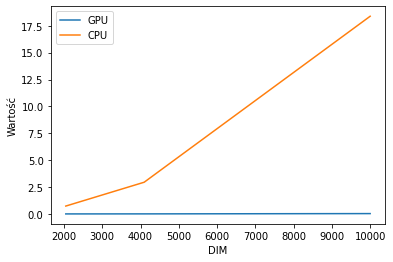

In [14]:
import matplotlib.pyplot as plt

# wartości DIM
dim_values = [2048, 4096, 10000]

# wartości dla GPU
gpu_values = [0.001373, 0.005391, 0.031361]

# wartości dla CPU
cpu_values = [0.731769, 2.948616, 18.385855]

# rysowanie wykresu liniowego z wartościami DIM jako oś x i wartościami GPU i CPU jako oś y
plt.plot(dim_values, gpu_values, label="GPU")
plt.plot(dim_values, cpu_values, label="CPU")

# dodanie etykiet dla osi x i y
plt.xlabel("DIM")
plt.ylabel("Wartość")

# dodanie legendy
plt.legend()

# wyświetlenie wykresu
plt.show()

Z wykresu można zauważyć, że dla większych rozmiarów obrazu (większej liczby pikseli) czas wykonania programu na GPU jest znacznie mniejszy niż na CPU. Zmiana czasu wykonania na CPU jest też bardziej widoczna niż na GPU. Można dojść do wniosku, że karty graficzne są lepsze do obliczeń wymagających dużych mocy obliczeniowych w porównaniu do procesorów CPU.